# Midterm ggplot2 Project - Julia Implementation
### Peter Dresslar, OMT548, Summer 2025

This notebook is my response to the midterm ggplot2 visualization project, originally designed for R but implemented here in Julia as an exploration of Julia's data visualization capabilities.

#### Required packages to run this notebook:
- DataFrames.jl (data manipulation)
- StatsPlots.jl (ggplot2-like plotting)
- RCall.jl (to access R's gapminder dataset---note that I have used this approach to convert many of the course's datasets from R.)
- Statistics (for median, etc.)
- TidierData.jl (for extremely fun data pipelining)

*To install: using Pkg; Pkg.add(["DataFrames", "DataFramesMeta", "StatsPlots", "RCall"])*

Note: I plan to make this notebook available via Binder/Pluto for online viewing.

---

In [41]:
using DataFrames
using StatsPlots
using RCall
using Statistics
using TidierData # this might be fun!

First, let's grab the data for our exercise: the `gapminder` dataset from R.

In [42]:
# Set CRAN mirror and install package: see previous exercises. Shooting for maximum portability here.
R"""
options(repos = c(CRAN = "https://cloud.r-project.org"))
suppressWarnings(suppressMessages({
  if (!require('gapminder', quietly = TRUE)) {
    install.packages('gapminder')
  }
  library(gapminder)
}))
"""

# Get the gapminder dataset into Julia. Though not strictly necessary, we coerce to a DataFrame.
gapminder = DataFrame(rcopy(R"gapminder"))

# let's mind the gapminder
println(describe(gapminder))

6×7 DataFrame
 Row │ variable   mean       min          median    max         nmissing  eltype                           
     │ Symbol     Union…     Any          Union…    Any         Int64     DataType                         
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ country               Afghanistan            Zimbabwe           0  CategoricalValue{String, UInt32}
   2 │ continent             Africa                 Oceania            0  CategoricalValue{String, UInt32}
   3 │ year       1979.5     1952         1979.5    2007               0  Int64
   4 │ lifeExp    59.4744    23.599       60.7125   82.603             0  Float64
   5 │ pop        2.96012e7  60011        7.0236e6  1318683096         0  Int64
   6 │ gdpPercap  7215.33    241.166      3531.85   1.13523e5          0  Float64


Okay, we already have some very solid information about `gapminder` in our description, since Julia's `describe()` is very similar to R's `str()`. Running `describe()` on a just-loaded data structure is very idiomatic Julia to check and make sure the load was successful.

We can check out the first few rows from the dataset to get an even better picture. Julia's `first()` is similar to R's `head()`. 

Also similar to R is the fact that in Julia we can simply execute the name of the `DataFrame` and get a print function executed that will (in the case of this type) print out the rows of data. The command is available below but commented out for size.

In [43]:
print(first(gapminder, 5))

# gapminder

5×6 DataFrame
 Row │ country      continent  year   lifeExp  pop       gdpPercap 
     │ Cat…         Cat…       Int64  Float64  Int64     Float64   
─────┼─────────────────────────────────────────────────────────────
   1 │ Afghanistan  Asia        1952   28.801   8425333    779.445
   2 │ Afghanistan  Asia        1957   30.332   9240934    820.853
   3 │ Afghanistan  Asia        1962   31.997  10267083    853.101
   4 │ Afghanistan  Asia        1967   34.02   11537966    836.197
   5 │ Afghanistan  Asia        1972   36.088  13079460    739.981

Next, we need to start running some basic statistics on our DataFrame. From the assignment:

> Summarizing median gdpPercap by continent

> Run the following chunk of code to summarize median `gdpPercap` by `continent` in the `year` 1952. Then, adjust the code to re-run for 1997. 

```{r}
# Summarize the median gdpPercap by continent in 1952
by_continent <- gapminder %>%
  filter(year == 1952) %>%
  group_by(continent) %>%
  summarize(medianGdpPercap = median(gdpPercap))

```

There are many ways to do this kind of work in Julia, but just for fun we can use the [TidierData.jl](https://tidierorg.github.io/TidierData.jl/latest/) package to take a "Tidy" approach to processing our data (that looks a bit like R Tidy!) For even more fun, we can compare to an approach that uses pure idiomatic Julia with no chaining.

In [44]:
# Summarizing median gdpPercap by continent in 1952, using TidierData.jl
tidier_gapminder = @chain gapminder begin
    @filter year == 1952
    @group_by continent
    @summarize medianGdpPercap = median(gdpPercap)
end

# compare to idiomatic Julia
filtered_gapminder = filter(row -> row.year == 1952, gapminder)
grouped_gapminder = groupby(filtered_gapminder, :continent)
idiomatic_gapminder = combine(grouped_gapminder, :gdpPercap => median => :medianGdpPercap)

# compare the two
println("TidierData.jl:")
println(tidier_gapminder)
println("Idiomatic Julia:")
# println(grouped_gapminder) # solving the sorting mystery...
println(idiomatic_gapminder)

TidierData.jl:
5×2 DataFrame
 Row │ continent  medianGdpPercap 
     │ Cat…       Float64         
─────┼────────────────────────────
   1 │ Asia              1206.95
   2 │ Europe            5142.47
   3 │ Africa             987.026
   4 │ Americas          3048.3
   5 │ Oceania          10298.1
Idiomatic Julia:
5×2 DataFrame
 Row │ continent  medianGdpPercap 
     │ Cat…       Float64         
─────┼────────────────────────────
   1 │ Africa             987.026
   2 │ Americas          3048.3
   3 │ Asia              1206.95
   4 │ Europe            5142.47
   5 │ Oceania          10298.1


Interestingly, Julia's `groupby()` sorts by default, which is what we might expect from our grouping function... TidierData.group_by does not sort by default. And, sure enough, if we dig into the R `dplyr` package documentation we can see that `group_by` there also does not sort by default. So, our `tidier_gapminder` seems more correct for this assignment.

In [45]:
# Summarizing median gdpPercap by continent in 1952, using TidierData.jl
tidier_gapminder_1997 = @chain gapminder begin
    @filter year == 1997
    @group_by continent
    @summarize medianGdpPercap = median(gdpPercap)
end

Row,continent,medianGdpPercap
,Cat…,Float64
1,Asia,3645.38
2,Europe,19596.5
3,Africa,1179.88
4,Americas,7113.69
5,Oceania,24024.2


As requested. It doesn't leap off the page, but perhaps the most surprising statistic here is the Americas failing to keep pace with Asia and Europe during a time period we might expect otherwise from.

On to our first plot!

```{r}
# Create a bar plot showing medianGdp by continent
ggplot(by_continent, aes(x = continent, y = medianGdpPercap)) +
  geom_col()
```

We can do this very straightforwardly in Julia, and we can even apply a similar theme. Let's also take the liberty to make a comparison plot with dual bars for 1952 and 1997.

10×3 DataFrame
 Row │ continent  medianGdpPercap  year   
     │ Cat…       Float64          String 
─────┼────────────────────────────────────
   1 │ Asia              1206.95   1952
   2 │ Europe            5142.47   1952
   3 │ Africa             987.026  1952
   4 │ Americas          3048.3    1952
   5 │ Oceania          10298.1    1952
   6 │ Asia              3645.38   1997
   7 │ Europe           19596.5    1997
   8 │ Africa            1179.88   1997
   9 │ Americas          7113.69   1997
  10 │ Oceania          24024.2    1997


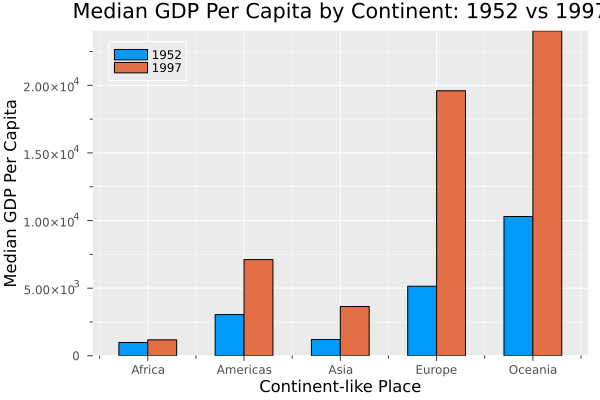

In [46]:
# theme for plots, should carry through the entire notebook
theme(:ggplot2)

# more tidierdata: https://tidierorg.github.io/TidierData.jl/latest/examples/generated/UserGuide/binding/
combined_very_tidy_data = @bind_rows(
    @mutate(tidier_gapminder, year = "1952"),
    @mutate(tidier_gapminder_1997, year = "1997")
)

println(combined_very_tidy_data)

# note we can now use the @df macro on combined_very_tidy_data to make a plot
@df combined_very_tidy_data groupedbar(:continent, :medianGdpPercap, 
    group=:year,
    xlabel="Continent-like Place",
    ylabel="Median GDP Per Capita", 
    title="Median GDP Per Capita by Continent: 1952 vs 1997",
    bar_width=0.6)

Genuinely, thank goodness for Bill Gates.

Okay, on to life expectancy:

> ## Summarizing median lifeExp by country
> Run the following chunk of code to summarize median `lifeExp` by `country`, limited to those countries in Oceania, in 2007. Then, adjust the code to re-run for the Americas ("`Americas`") in 1987. Save this new `dplyr` filter as `by_country_americas` instead of `by_country_oceania`. Be sure to call the correct dataframe when plotting below.


```{r}
# Summarize the median lifeExp by country, limited to those countries in Oceania, in 2007
by_country_oceania <- gapminder %>%
  filter(year == 2007, continent == "Oceania") %>%
  group_by(country) %>%
  summarize(medianlifeExp = median(lifeExp))

# Create a bar plot showing lifeExp by continent
ggplot(by_country_oceania, aes(x = country, y = medianlifeExp)) +
  geom_col()
```

Here we go:

2×2 DataFrame
 Row │ country      medianlifeExp 
     │ String       Float64       
─────┼────────────────────────────
   1 │ Australia           81.235
   2 │ New Zealand         80.204


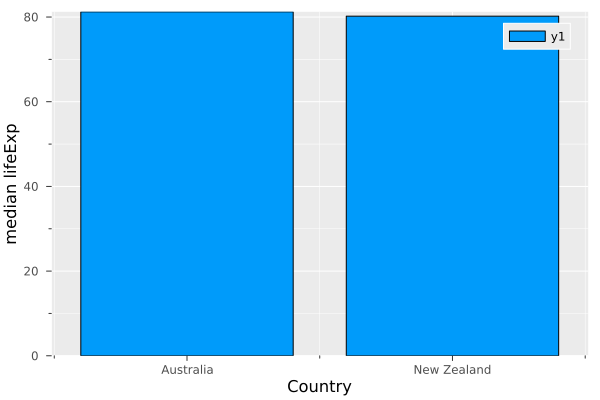

In [47]:
# Summarizing median lifeExp by country, Oceania in 2007

oceania_2007 = @chain gapminder begin
    @filter(year == 2007, continent == "Oceania") # could instead use a bitwise & operator
    @group_by country
    @summarize medianlifeExp = median(lifeExp)
    # we have a chore that we need to handle to make country a categorical variable for the plot...
    @mutate(country = string(country))
    # commenting out the above line will make a mess of the X axis tick labels.
end

println(oceania_2007)


# Create a bar plot showing lifeExp by continent
@df oceania_2007 bar(:country, :medianlifeExp,
    xlabel="Country",
    ylabel="median lifeExp")

## Plotting *Challenge*

Now for even more fun! We need to recreate a couple of plots from the assignment, as closely as we can.

#### Graph 1

Graph one pits Life expectancy against GDP with coloring for each "Continent" Let's see how well we can replicate it in Julia!

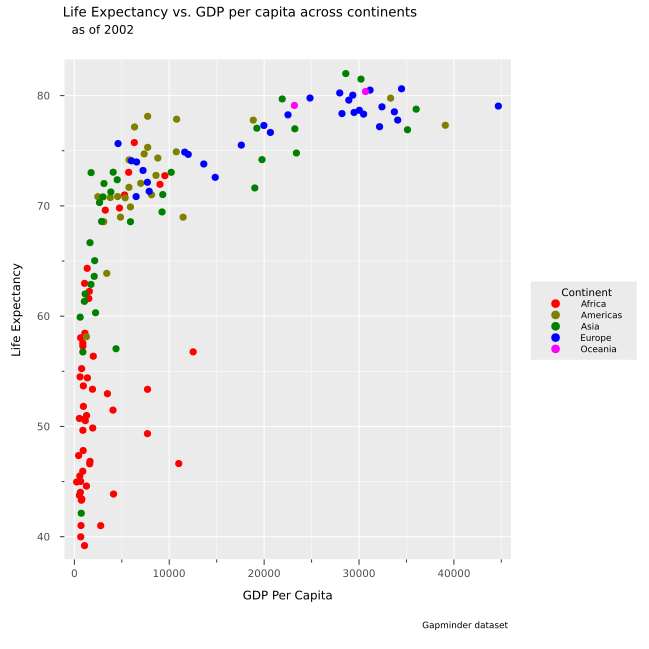

In [48]:
# first let's get our data filtered and happy
graph_1_data = @chain gapminder begin
    @filter(year == 2002)
end

# woohoo! help with annotations! https://discourse.julialang.org/t/adding-arbitrary-text-to-plots-jl-output/108262/5
# hmmm, less fun, more challenging, for the tick labels: https://discourse.julialang.org/t/plots-jl-clean-scientific-formatting/38112/3

subhead = text("as of 2002", :black, :left, 8)
footer = text("Gapminder dataset", :black, :right, 6)
clean_tick_labels(n) = string(Int(round(n, digits=0)))
custom_colors = [
    :red,        # Africa
    :olive,      # Americas  
    :green,      # Asia
    :blue,       # Europe
    :magenta     # Oceania
]

graph_1 = @df graph_1_data scatter(:gdpPercap, :lifeExp, group=:continent,
    xlabel="\nGDP Per Capita\n\n",
    ylabel="Life Expectancy\n",
    size=(650, 650),  # legend at the bottom makes sizing a challenge.
    palette=custom_colors,
    title="Life Expectancy vs. GDP per capita across continents\n\n",  # nightmarish format hacks!
    formatter=clean_tick_labels,
    legend=:outerright,
    legendtitle="Continent",
    titlelocation=:left,
    titlefontsize=9,
    legendfontsize=6,
    legendtitlefontsize=7,
    labelfontsize=8,
    tickfontsize=7
)

# Our most tricky elements...
annotate!(graph_1, [(-220, 86, subhead)])  # can't even get to the left edge.
annotate!(graph_1, [(45678, 32, footer)])  # oh come on.

# Display the plot
display(graph_1)



Well! That got a bit out of hand. Hopefully we are in the ballpark of the original. Surely we can reuse all these format hacks for the next graph.

(Inspects https://www.public.asu.edu/~jbronowi/Gapminder2.png ...)

*nooooooooooooooooooooooo*

Unfortunately, there really is not a good analogue for `theme_fivethirtyeight` in Julia PlotThemes. The closest might be `:sand` and it handles legend text annoyingly. 

We'll use the `:dark` PlotTheme, and hopefully live the difference. Note that we are once again using the `custom_colors` `pallete` because we cannot otherwise mimic the color scale in the base plot.

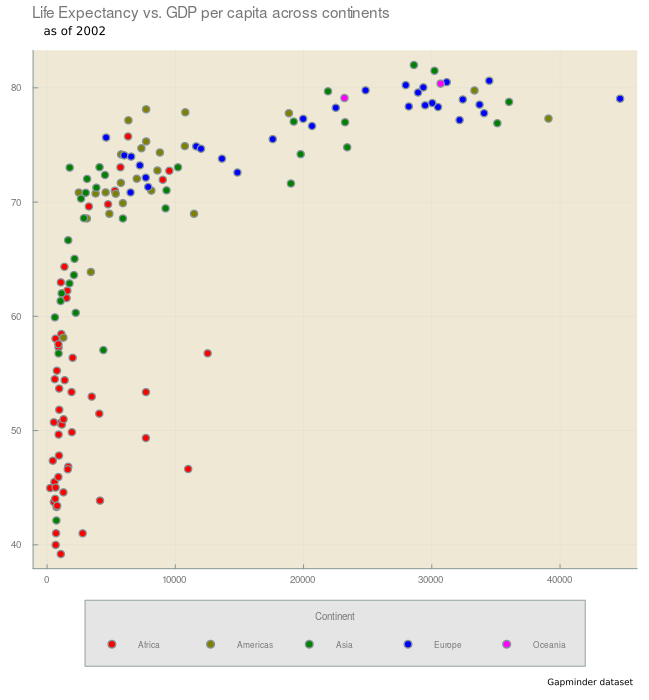

In [49]:
theme(:solarized_light)

subhead_2 = text("as of 2002", :black, :left, 8)
footer_2 = text("Gapminder dataset", :black, :right, 6)

graph_2 = @df graph_1_data scatter(:gdpPercap, :lifeExp, group=:continent,
    palette=custom_colors,
    fontfamily="Helvetica",
    background_color_outside=:white, # stock solarized_light bg is ugly.
    background_color=:gray90,
    size=(650, 700),  # legend at the bottom makes sizing a challenge.
    # xlabel="\nGDP Per Capita",  # to the bin with you labels!
    # ylabel="Life Expectancy\n",
    # labelfontsize=8,

    title="Life Expectancy vs. GDP per capita across continents\n",  # a more typical format hack.
    titlelocation=:left,
    titlefontsize=11,
    titlefontweight=:bold,
    titlefontcolor=:black,

    formatter=clean_tick_labels,
    tickfontsize=7,
    tickfontcolor=:black,

    legend=:outerbottom,
    legendcolumns=5,
    legendtitle="Continent\n",
    legendfontsize=6,
    legendtitlefontsize=7,
    legendfontcolor=:black,
    legendtitlefontcolor=:black,
)

# Our most tricky elements...
annotate!(graph_2, [(-220, 85, subhead_2)])  # STILL can't even get to the left edge.
annotate!(graph_2, [(45678, 28, footer_2)])  # i might actually have bad dreams about this.

# Display the plot
display(graph_2)

Unfortunately, `solarized_light` is a challenge to format and override (particularly the legend), so we'll have to settle for what we have here. It could be customized, but that seems a bridge too far for the moment. Still, the plot looks reasonably informative!